# Gaussian Process Regression

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from utils import nc_to_pd, prepare_simulated

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, DotProduct, ExpSineSquared

In [2]:
if sys.platform == 'win32':
    save_folder = "F:/Google Drive/Dropbox_Backup/Post Study/Industrial/Courses/DTU Advanced Machine Learning, 2020/gaussian_solar_project/data/"
else:
    save_folder = "/home/local/DAC/ahn/Documents/dcwis.solar/dcwis/solar/reports/dtu/"

In [3]:
meuro_sim = pd.read_csv(save_folder + 'meuro_simulated.csv', skiprows=[0,1,2])
neuhardenberg_sim = pd.read_csv(save_folder + 'neuhardenberg_simulated.csv', skiprows=[0,1,2])
templin_sim = pd.read_csv(save_folder + 'templin_simulated.csv', skiprows=[0,1,2])

In [4]:
meuro_irradiance = pd.read_csv(save_folder + 'irradiance_meuro_data.csv').set_index('time')
meuro_irradiance.index = pd.to_datetime(meuro_irradiance.index, utc=True)

neuhardenberg_irradiance = pd.read_csv(save_folder + 'irradiance_neuhardenberg_data.csv').set_index('time')
neuhardenberg_irradiance.index = pd.to_datetime(neuhardenberg_irradiance.index, utc=True)

templin_irradiance = pd.read_csv(save_folder + 'irradiance_templin_data.csv').set_index('time')
templin_irradiance.index = pd.to_datetime(templin_irradiance.index, utc=True)

In [5]:
# prepare our simulated dataframes
meuro_sim = prepare_simulated(meuro_sim, meuro_irradiance.index)
neuhardenberg_sim = prepare_simulated(neuhardenberg_sim, neuhardenberg_irradiance.index)
templin_sim = prepare_simulated(templin_sim, templin_irradiance.index)

# Regression

In [6]:
%pylab inline  
import GPy
import GPyOpt
from numpy.random import seed
import matplotlib

Populating the interactive namespace from numpy and matplotlib


In [7]:
# We need a function to optimize. As an initial start, we choose a simple linear model

def f(x):
    return (6*x-2)**2*np.sin(12*x-4)

f= GPyOpt.objective_examples.experiments1d.forrester()   

In [8]:
# We bound this interval of x in [0, 500] as we assume irradiance cannot go above this value

bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]

In [9]:
# We instantiate the object to find the minimum of f in our selected region.
Problem = GPyOpt.methods.BayesianOptimization(f.f, bounds)

In [10]:
# We run the optimization given our budget
max_iter = 15     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the las two observations

Problem.run_optimization(max_iter, max_time, eps)  

In [11]:
# We can find the best solution of x
Problem.x_opt

array([0.76210897])

In [12]:
# And the predicted value of f at the optimum x*
Problem.fx_opt

-6.007954703770779

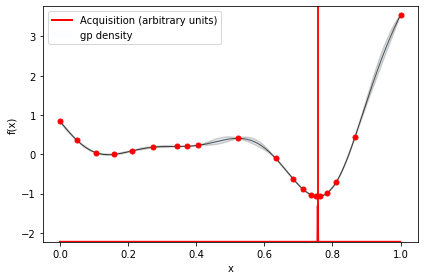

In [13]:
Problem.plot_acquisition()

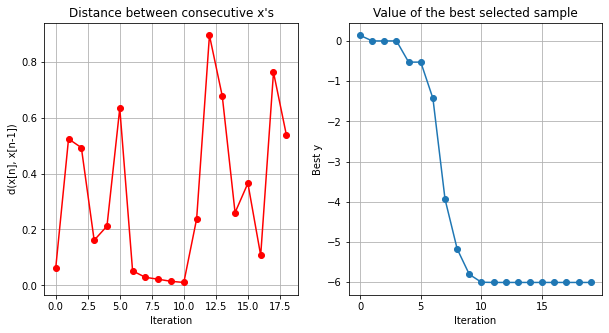

In [14]:

Problem.plot_convergence()

# FOR OUR PROBLEM

In [15]:
import numpy as np

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
        
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [16]:
x = neuhardenberg_irradiance / np.linalg.norm(neuhardenberg_irradiance)

[]

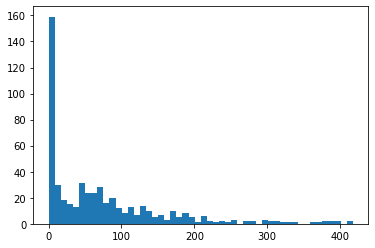

In [17]:
plt.hist(neuhardenberg_irradiance.values.ravel(), bins=50)
plt.plot()

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D



def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)

In [19]:
xpts = np.linspace(0, 500, num=10000)

In [20]:
x = neuhardenberg_irradiance
y = neuhardenberg_sim

In [91]:
# noise = 0.4
noise = 0.4

In [92]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, ExpSineSquared

In [133]:
rbf =  ConstantKernel(2) *RBF(length_scale=0.5) * ExpSineSquared(length_scale=2, periodicity=3)  # ConstantKernel(1.0) *  
# rbf = ConstantKernel(1.0) * RBF(length_scale=0.5) * ExpSineSquared()
# rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2, normalize_y=True)


In [134]:
# Reuse training data from previous 1D example
gpr.fit(x.values.reshape(-1, 1), y.values.ravel())

GaussianProcessRegressor(alpha=0.16000000000000003,
                         kernel=1.41**2 * RBF(length_scale=0.5) * ExpSineSquared(length_scale=2, periodicity=3),
                         normalize_y=True)

In [135]:
# Compute posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(xpts.reshape(-1, 1), return_cov=True)


In [136]:
# # Obtain optimized kernel parameters
# l = gpr.kernel_.k2.get_params()['length_scale']
# sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

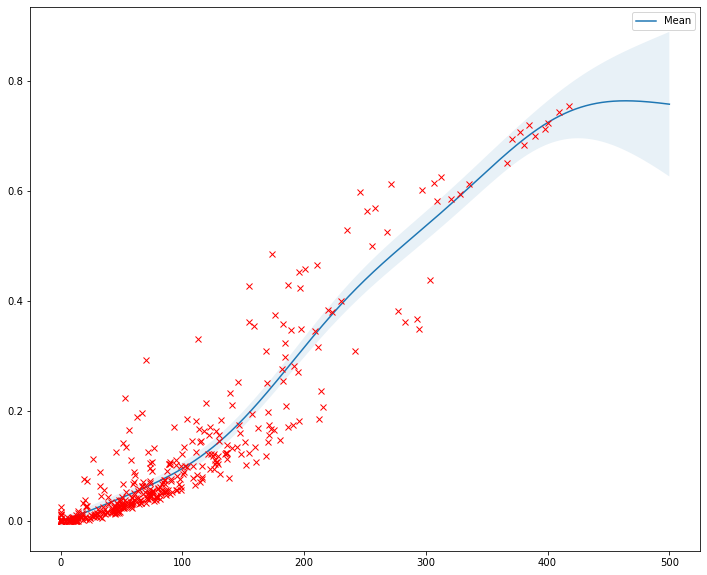

In [137]:
# Plot the results
plt.figure(figsize=(12,10))
plot_gp(mu_s, cov_s, xpts, X_train=x, Y_train=y)

In [ ]:
# import GPy

# rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=2.0)
# gpr = GPy.models.GPRegression(x, y, rbf)

# # Fix the noise variance to known value 
# gpr.Gaussian_noise.variance = noise**2
# gpr.Gaussian_noise.variance.fix()

# # Run optimization
# gpr.optimize();

# # Obtain optimized kernel parameters
# l = gpr.rbf.lengthscale.values[0]
# sigma_f = np.sqrt(gpr.rbf.variance.values[0])


In [ ]:
# # Plot the results with the built-in plot function
# gpr.plot(figsize=(12,10));